In [1]:
# biosignalsnotebooks python package
import biosignalsnotebooks as bsnb

# Scientific packages
from numpy import linspace, diff, zeros_like, arange, array
import numpy as np
import matplotlib.pyplot as plt


In [10]:
folder_name = 'Data'
file_name = 'baseline_zeyu_trial1.txt'

In [11]:
# Load entire acquisition data.
data, header = bsnb.load(f"{folder_name}/{file_name}", get_header=True)

In [12]:
# signal = data['CH2'][70000:-10000]
# signal = data['CH2'][5000:60000]
signal = data['CH2'][10000:-10000]
# Sampling rate definition.
sr = header["sampling rate"]
time = np.array(bsnb.generate_time(signal, sr))

In [13]:
def label_signals(signal, time, ):
    # Step 1 of Pan-Tompkins Algorithm
    filtered_signal = bsnb.detect._ecg_band_pass_filter(signal, sr)
    # Step 2 of Pan-Tompkins Algorithm
    differentiated_signal = diff(filtered_signal)
    # Step 3 of Pan-Tompkins Algorithm
    squared_signal = differentiated_signal * differentiated_signal
    nbr_sampls_int_wind = int(0.080 * sr)
    integrated_signal = zeros_like(squared_signal)
    cumulative_sum = squared_signal.cumsum()
    integrated_signal[nbr_sampls_int_wind:] = (cumulative_sum[nbr_sampls_int_wind:] - 
                                            cumulative_sum[:-nbr_sampls_int_wind]) / nbr_sampls_int_wind
    integrated_signal[:nbr_sampls_int_wind] = cumulative_sum[:nbr_sampls_int_wind] / arange(1, nbr_sampls_int_wind + 1)
    rr_buffer, signal_peak_1, noise_peak_1, threshold = bsnb.detect._buffer_ini(integrated_signal, sr)
    probable_peaks, possible_peaks= bsnb.detect._detects_peaks(integrated_signal, sr)

    definitive_peaks = bsnb.detect._checkup(probable_peaks, integrated_signal, sr, rr_buffer, signal_peak_1, noise_peak_1, threshold)

    # Conversion to integer type.
    definitive_peaks = array(list(map(int, definitive_peaks)))
    map_integers = definitive_peaks - 40 * (sr / 1000)
    definitive_peaks_reph = array(list(map(int, map_integers)))
    return definitive_peaks_reph, integrated_signal, differentiated_signal

In [14]:
def graph_ecg(Sig, time):
    fig, axs = plt.subplots(1, 1, figsize=(10, 8), sharex=True)

    # Plot accelerometer data
    axs.plot(time, Sig)
    axs.set_ylabel('X Axis')
    axs.grid(True)
    # Set title for the entire plot
    plt.suptitle('ECG Data')

    # Adjust layout
    plt.tight_layout()

    # Display the plot
    plt.show()

In [15]:
definitive_peaks_reph, integrated_signal, differentiated_signal = label_signals(signal, time)

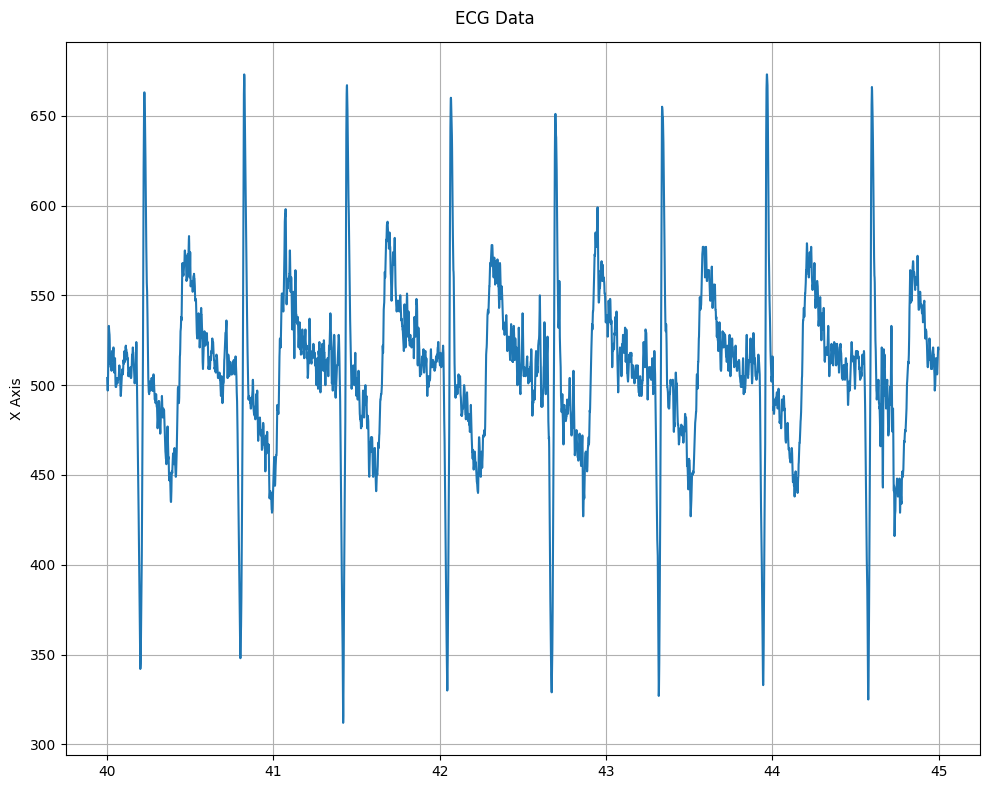

In [16]:
graph_ecg(signal[40000:45000], time[40000:45000])

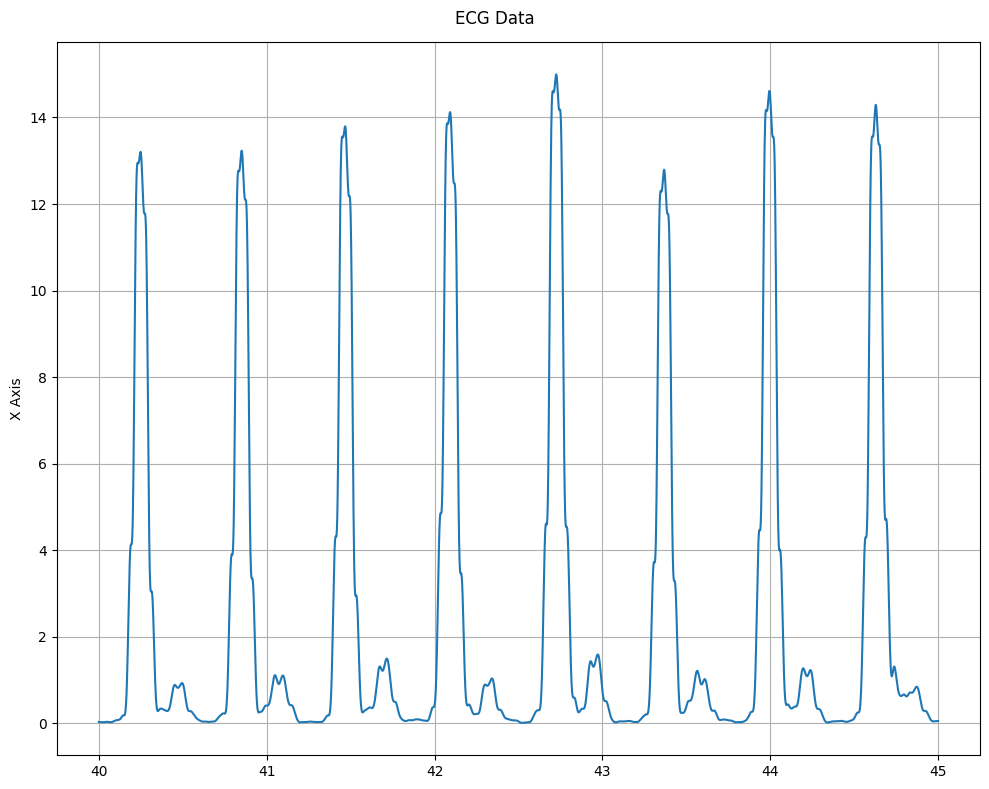

In [17]:
graph_ecg(integrated_signal[40000:45000], time[40000:45000])

In [23]:
mask = (definitive_peaks_reph >= 40000) & (definitive_peaks_reph <= 45000)

# Apply the mask to the original array
smaller_array = definitive_peaks_reph[mask]

In [13]:
print(definitive_peaks_reph)

[    17    665   1294   1920   2559   3139   3753   4352   5010   5632
   6245   6879   7503   8114   8770   9359   9977  10613  11238  11866
  12470  13047  13682  14314  14957  15555  16140  16758  17382  18016
  18633  19250  19882  20517  21147  21778  22364  22983  23630  24257
  24858  25440  26059  26697  27340  27969  28582  29221  29861  30505
  31098  31701  32326  32957  33559  34149  34747  35381  35951  36579
  37176  37765  38385  38993  39638  40253  40857  41494  42128  42760
  43356  43899  44516  45112  45665  46196  46774  47363  47921  48500
  49046  49635  50226  50841  51402  51998  52571  53193  53747  54372
  54934  55538  56143  56772  57350  57920  58545  59160  59798  60404
  60977  61590  62192  62823  63456  64051  64646  65228  65848  66467
  67066  67651  68250  68881  69463  70052  70636  71225  71841  72449
  73064  73635  74202  74802  75397  75996  76572  77133  77718  78258
  78812  79386  79959  80506  81086  81646  82245  82860  83485  84106
  8468

In [14]:
peak_gap = np.diff(definitive_peaks_reph)
print(peak_gap)

[648 629 626 639 580 614 599 658 622 613 634 624 611 656 589 618 636 625
 628 604 577 635 632 643 598 585 618 624 634 617 617 632 635 630 631 586
 619 647 627 601 582 619 638 643 629 613 639 640 644 593 603 625 631 602
 590 598 634 570 628 597 589 620 608 645 615 604 637 634 632 596 543 617
 596 553 531 578 589 558 579 546 589 591 615 561 596 573 622 554 625 562
 604 605 629 578 570 625 615 638 606 573 613 602 631 633 595 595 582 620
 619 599 585 599 631 582 589 584 589 616 608 615 571 567 600 595 599 576
 561 585 540 554 574 573 547 580 560 599 615 625 621 578 601 638 642 643
 636 604 654 636 655 630 588 599 644 619 649 644 620 607 662 666 644 640
 601 634 641 660 612 585 621 617 626 594 635 605 648 654 636 625 588 666
 689 644 675 591 608 634 641 600 584 602 633 634 619 596 601 620 635 644
 646 605 649 654 665 610 578 601 621 654 625 607 580 626 648 645 636 591
 632 636 664 619 596 600 657 661 645 624 614 666 609 629 604 600 621 639
 603 613 620 625 625 602 612 597 629 652 601 585 63

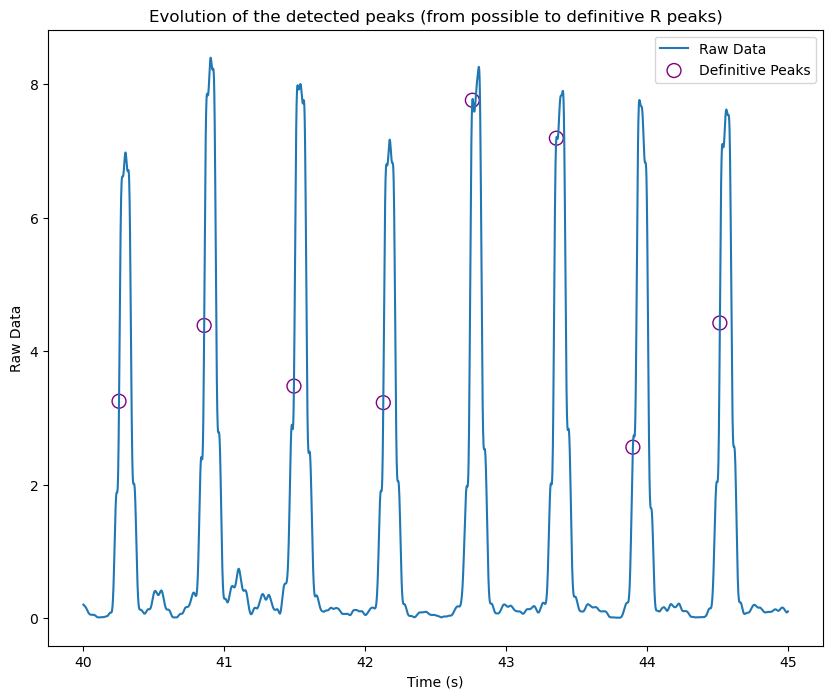

In [24]:
# Plotting the raw ECG data
plt.figure(figsize=(10, 8))
plt.plot(time[40000:45000], integrated_signal[40000:45000], label='Raw Data')

# Plotting the definitive peaks
plt.scatter([time[i] for i in smaller_array], [integrated_signal[i] for i in smaller_array], s=100, edgecolor='purple', facecolors='none', label='Definitive Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Raw Data')
plt.title('Evolution of the detected peaks (from possible to definitive R peaks)')
plt.legend()
plt.show()

In [24]:
def split_signal_by_peaks(integrated_signal, signal, peak_indices, label):
    # Initialize lists to store segmented signals
    integrated_segments = []
    signal_segments = []
    labels = []
    # Split the integrated_signal and signal based on peak indices
    for i in range(len(peak_indices) - 1):
        start_index = peak_indices[i]
        end_index = peak_indices[i + 1]
        integrated_segments.append(integrated_signal[start_index:end_index])
        signal_segments.append(signal[start_index:end_index])
        labels.append(label)
    
    return integrated_segments, signal_segments, labels

In [121]:
integrated_segments, signal_segments, labels = split_signal_by_peaks(integrated_signal, signal, definitive_peaks_reph, label=0)
# Not distracted

In [115]:
integrated_segments, signal_segments, labels = split_signal_by_peaks(integrated_signal, signal, definitive_peaks_reph, label=1)
# Distracted

In [14]:
import json
import os

def append_to_json_file(data, filename):
    # Check if the file exists
    if os.path.exists(filename):
        # If the file exists, load its contents
        with open(filename, 'r') as file:
            existing_data = json.load(file)
        # Append new data to the existing data
        existing_data.extend(data)
        # Write the combined data back to the file
        with open(filename, 'w') as file:
            json.dump(existing_data, file, indent=4)
    else:
        # If the file doesn't exist, create it and write the data
        with open(filename, 'w') as file:
            json.dump(data, file, indent=4)

In [122]:
# Example usage:
# Define the filename
filename = "Jinghao_ECG_2.json"
data_to_append = []
# Iterate over the segmented signals and labels
for i in range(len(integrated_segments)):
    # Create a dictionary for each segment and its corresponding label
    segment_data = {
        "integrated_segment": integrated_segments[i].tolist(),  # Convert numpy array to list
        "signal_segment": signal_segments[i].tolist(),          # Convert numpy array to list
        "label": labels[i]
    }
    # Append the segment data to the list
    data_to_append.append(segment_data)

# Append the data to the JSON file
append_to_json_file(data_to_append, filename)